# Read multiple sweeps to create a volume scan with xradar and datatree
This example show how create a volume scan using multiple sweep files from AWS.
## Imports

In [1]:
import pyart
import fsspec
import xarray as xr
import xradar as xd
import boto3
import botocore
import numpy as np
import cartopy.crs as ccrs
from pandas import to_datetime
import matplotlib.pyplot as plt
from botocore.client import Config
from datetime import datetime
from matplotlib import pyplot
from pyart.graph import cm
from datatree import DataTree, open_datatree
# pyplot.style.use('dark_background')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Access radar data from Colombian radar network on AWS
Access data from IDEAM bucket on AWS. Detailed information can be found [here](https://github.com/aladinor/notebooks/blob/origin/master/IDEAM_Radar_from_AWS.ipynb) 

In [2]:
def create_query(date, radar_site):
    """
    Creates a string for quering the IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a IDEAM radar bucket format
    """
    return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'

In [3]:
date_query = datetime(2023, 3, 27)
radar_name = "Barrancabermeja" 
query = create_query(date=date_query, radar_site=radar_name)

In [4]:
str_bucket = 's3://s3-radaresideam/'
s3 = boto3.resource('s3',
                    config=Config(signature_version=botocore.UNSIGNED, 
                                  user_agent_extra='Resource'))

bucket = s3.Bucket('s3-radaresideam')

radar_files = [f'{str_bucket}{i.key}' for i in bucket.objects.filter(Prefix=f"{query}")]
radar_files[:4]

['s3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000004.RAWZ84V',
 's3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000107.RAWZ84Z',
 's3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000239.RAWZ852',
 's3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000316.RAWZ855']

## Let's check elevation at each files using PyArt

IDEAM radar network operates with a volume scan every five minutes. Each volume scan has four different tasks 
* *SURVP* "super resolution" sweep at the lowest elevation angle, usually 0.5 deg,  with 720 degrees in azimuth (every 0.5 deg)
* *PRECA* task with 1.5, 2.4, 3.0, and 5.0 elevation angles and shorter range than *SURP*
* *PRECB* task with 6.4 and 8.0 elevation angles and shorter range than previous task
* *PRECC* task with 10.0, 12.5, and 15.0 with shorter range than previous task as well

In [5]:
for i in radar_files[:8]:
    of = pyart.io.prepare_for_read(i, storage_options={'anon': True})
    with of as f:
        radar = pyart.io.read(f)
        print(i)
        print(f"radar elevation {radar.fixed_angle['data']}")
        print(f" task name : {radar.metadata['sigmet_task_name']}")
        print('--------------------------------------------------------')
        f.close()

/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/pyart/io/sigmet.py:146: RuntimeWarning: invalid value encountered in sqrt
  sigmet_data, sigmet_metadata = sigmetfile.read_data(full_xhdr=full_xhdr)


s3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000004.RAWZ84V
radar elevation [1.3018799]
 task name : b'SURVP       '
--------------------------------------------------------
s3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000107.RAWZ84Z
radar elevation [1.4996338 2.4005127 3.0981445 5.0976562]
 task name : b'PRECA       '
--------------------------------------------------------
s3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000239.RAWZ852
radar elevation [6.399536 7.998047]
 task name : b'PRECB       '
--------------------------------------------------------
s3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000316.RAWZ855
radar elevation [ 9.997559 12.502441 15.001831]
 task name : b'PRECC       '
--------------------------------------------------------
s3://s3-radaresideam/l2_data/2023/03/27/Barrancabermeja/BAR230327000504.RAWZ85B
radar elevation [1.3018799]
 task name : b'SURVP       '
-----------------------------

## Create a  sigle volume scan using four taks 
Let's use the first four files, tasks *SURVP*, *PRECA*, *PRECB*, *PRECC*, to create a single volume scan 

In [6]:
# List of task files
task_files = [fsspec.open_local(f'simplecache::{i}', s3={'anon': True}, filecache={'cache_storage': '.'}) 
             for i in radar_files[:4]]

To create a single vcp object with all sweeps we need to create a datatree object with all tasks and its own sweeps

In [7]:
# list of xradar datatrees
ls_dt = [xd.io.open_iris_datatree(i).xradar.georeference() for i in task_files]

Now that we have each task as a Datatree we can create our Datatree object with all task as children.

In [8]:
vcp_dt = DataTree(name='root', children=dict(SURVP=ls_dt[0], PRECA=ls_dt[1], PRECB=ls_dt[2], PRECC=ls_dt[3]))

In [9]:
vcp_dt

DataTree('root', parent=None)
├── DataTree('SURVP')
│   │   Dimensions:              ()
│   │   Data variables:
│   │       volume_number        int64 0
│   │       platform_type        <U5 'fixed'
│   │       instrument_type      <U5 'radar'
│   │       time_coverage_start  <U20 '2023-03-27T00:00:04Z'
│   │       time_coverage_end    <U20 '2023-03-27T00:01:05Z'
│   │       longitude            float64 -73.76
│   │       altitude             float64 105.0
│   │       latitude             float64 6.933
│   │   Attributes:
│   │       Conventions:      None
│   │       version:          None
│   │       title:            None
│   │       institution:      None
│   │       references:       None
│   │       source:           None
│   │       history:          None
│   │       comment:          im/exported using xradar
│   │       instrument_name:  None
│   └── DataTree('sweep_0')
│           Dimensions:            (azimuth: 720, range: 994)
│           Coordinates:
│             * azimuth            (azimuth) float64 0.03021 0.5191 1.027 ... 359.0 359.5
│               elevation          (azimuth) float64 1.318 1.318 1.318 ... 1.318 1.318 1.318
│               time               (azimuth) datetime64[ns] 2023-03-27T00:00:42.572000 .....
│             * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│               longitude          float64 -73.76
│               latitude           float64 6.933
│               altitude           float64 105.0
│               spatial_ref        int64 0
│               x                  (azimuth, range) float64 0.5272 0.6853 ... -2.504e+03
│               y                  (azimuth, range) float64 999.7 1.3e+03 ... 2.984e+05
│               z                  (azimuth, range) float64 128.1 135.0 ... 1.223e+04
│           Data variables: (12/17)
│               DBTH               (azimuth, range) float32 ...
│               DBZH               (azimuth, range) float32 ...
│               VRADH              (azimuth, range) float32 ...
│               WRADH              (azimuth, range) float32 ...
│               ZDR                (azimuth, range) float32 ...
│               KDP                (azimuth, range) float32 ...
│               ...                 ...
│               DB_DBZE8           (azimuth, range) int16 ...
│               sweep_mode         <U20 ...
│               sweep_number       int64 ...
│               prt_mode           <U7 ...
│               follow_mode        <U7 ...
│               sweep_fixed_angle  float64 ...
├── DataTree('PRECA')
│   │   Dimensions:              ()
│   │   Data variables:
│   │       volume_number        int64 0
│   │       platform_type        <U5 'fixed'
│   │       instrument_type      <U5 'radar'
│   │       time_coverage_start  <U20 '2023-03-27T00:01:08Z'
│   │       time_coverage_end    <U20 '2023-03-27T00:02:36Z'
│   │       longitude            float64 -73.76
│   │       altitude             float64 105.0
│   │       latitude             float64 6.933
│   │   Attributes:
│   │       Conventions:      None
│   │       version:          None
│   │       title:            None
│   │       institution:      None
│   │       references:       None
│   │       source:           None
│   │       history:          None
│   │       comment:          im/exported using xradar
│   │       instrument_name:  None
│   ├── DataTree('sweep_0')
│   │       Dimensions:            (azimuth: 360, range: 747)
│   │       Coordinates:
│   │         * azimuth            (azimuth) float64 0.04395 1.071 2.032 ... 358.1 359.1
│   │           elevation          (azimuth) float64 1.472 1.472 1.472 ... 1.472 1.472 1.472
│   │           time               (azimuth) datetime64[ns] 2023-03-27T00:01:18.841000 .....
│   │         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│   │           longitude          float64 -73.76
│   │           latitude           float64 6.933
│   │           altitude           float64 105.0
│

In [10]:
print(f"Size of data in tree = {vcp_dt.nbytes / 1e6 :.2f} MB")

Size of data in tree = 192.58 MB


## Creating a PPI plot from Datatree object

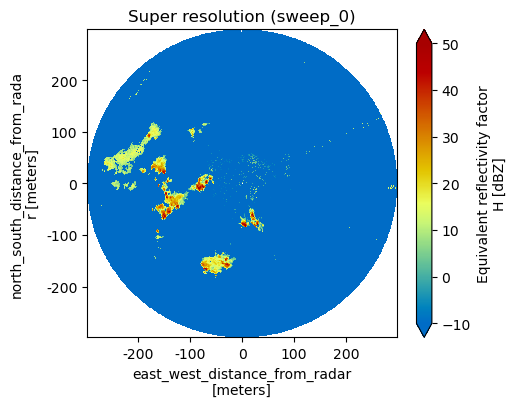

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
vcp_dt.SURVP.sweep_0.DBZH.plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50, ax=ax)
ax.set_title("Super resolution (sweep_0)")
m2km = lambda x, _: f"{x/1000:g}"
ax.xaxis.set_major_formatter(m2km)
ax.yaxis.set_major_formatter(m2km)

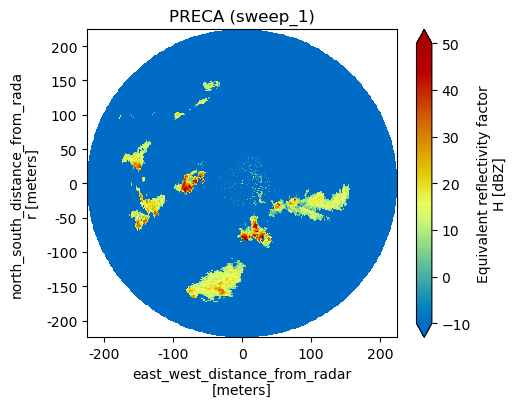

In [12]:
fig, ax = plt.subplots(figsize=(5, 4))
vcp_dt.PRECA.sweep_1.DBZH.plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50, ax=ax)
ax.set_title("PRECA (sweep_1)")
m2km = lambda x, _: f"{x/1000:g}"
ax.xaxis.set_major_formatter(m2km)
ax.yaxis.set_major_formatter(m2km)


## Multiple volume scans into one `datatree` object

In [13]:
def data_accessor(file):
    return fsspec.open_local(f'simplecache::{file}', s3={'anon': True}, filecache={'cache_storage': '.'})

def create_vcp(ls_dt):
    return DataTree(name='root', children=dict(SURVP=ls_dt[0], PRECA=ls_dt[1], PRECB=ls_dt[2], PRECC=ls_dt[3]))

def mult_vcp(radar_files):
    ls_files = [radar_files[i:i+4] for i in range(len(radar_files)) if i % 4 == 0]
    ls_dt = [[xd.io.open_iris_datatree(data_accessor(i)).xradar.georeference() for i in j] for j in ls_files]    
    return [create_vcp(i) for i in ls_dt]

In [14]:
ls_dt = mult_vcp(radar_files[:24])

In [15]:
dt_vcp = DataTree.from_dict({f'vpc_{idx}': i for idx, i in enumerate(ls_dt)})

In [16]:
dt_vcp

DataTree('None', parent=None)
├── DataTree('vpc_0')
│   ├── DataTree('SURVP')
│   │   │   Dimensions:              ()
│   │   │   Data variables:
│   │   │       volume_number        int64 0
│   │   │       platform_type        <U5 'fixed'
│   │   │       instrument_type      <U5 'radar'
│   │   │       time_coverage_start  <U20 '2023-03-27T00:00:04Z'
│   │   │       time_coverage_end    <U20 '2023-03-27T00:01:05Z'
│   │   │       longitude            float64 -73.76
│   │   │       altitude             float64 105.0
│   │   │       latitude             float64 6.933
│   │   │   Attributes:
│   │   │       Conventions:      None
│   │   │       version:          None
│   │   │       title:            None
│   │   │       institution:      None
│   │   │       references:       None
│   │   │       source:           None
│   │   │       history:          None
│   │   │       comment:          im/exported using xradar
│   │   │       instrument_name:  None
│   │   └── DataTree('sweep_0')
│   │           Dimensions:            (azimuth: 720, range: 994)
│   │           Coordinates:
│   │             * azimuth            (azimuth) float64 0.03021 0.5191 1.027 ... 359.0 359.5
│   │               elevation          (azimuth) float64 1.318 1.318 1.318 ... 1.318 1.318 1.318
│   │               time               (azimuth) datetime64[ns] 2023-03-27T00:00:42.572000 .....
│   │             * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│   │               longitude          float64 -73.76
│   │               latitude           float64 6.933
│   │               altitude           float64 105.0
│   │               spatial_ref        int64 0
│   │               x                  (azimuth, range) float64 0.5272 0.6853 ... -2.504e+03
│   │               y                  (azimuth, range) float64 999.7 1.3e+03 ... 2.984e+05
│   │               z                  (azimuth, range) float64 128.1 135.0 ... 1.223e+04
│   │           Data variables: (12/17)
│   │               DBTH               (azimuth, range) float32 ...
│   │               DBZH               (azimuth, range) float32 ...
│   │               VRADH              (azimuth, range) float32 ...
│   │               WRADH              (azimuth, range) float32 ...
│   │               ZDR                (azimuth, range) float32 ...
│   │               KDP                (azimuth, range) float32 ...
│   │               ...                 ...
│   │               DB_DBZE8           (azimuth, range) int16 ...
│   │               sweep_mode         <U20 ...
│   │               sweep_number       int64 ...
│   │               prt_mode           <U7 ...
│   │               follow_mode        <U7 ...
│   │               sweep_fixed_angle  float64 ...
│   ├── DataTree('PRECA')
│   │   │   Dimensions:              ()
│   │   │   Data variables:
│   │   │       volume_number        int64 0
│   │   │       platform_type        <U5 'fixed'
│   │   │       instrument_type      <U5 'radar'
│   │   │       time_coverage_start  <U20 '2023-03-27T00:01:08Z'
│   │   │       time_coverage_end    <U20 '2023-03-27T00:02:36Z'
│   │   │       longitude            float64 -73.76
│   │   │       altitude             float64 105.0
│   │   │       latitude             float64 6.933
│   │   │   Attributes:
│   │   │       Conventions:      None
│   │   │       version:          None
│   │   │       title:            None
│   │   │       institution:      None
│   │   │       references:       None
│   │   │       source:           None
│   │   │       history:          None
│   │   │       comment:          im/exported using xradar
│   │   │       instrument_name:  None
│   │   ├── DataTree('sweep_0')
│   │   │       Dimensions:            (azimuth: 360, range: 747)
│   │   │       Coordinates:
│   │   │         * azimuth            (azimuth) float64 0.04395 1.071 2.032 ... 358.1 359.1
│   │   │           elevation          (azimuth) float64 1.472 1.472 1.472 ... 1.472 1.472 1.472
│   │   │

In [17]:
print(f"Size of data in tree = {dt_vcp.nbytes / 1e6 :.2f} MB")

Size of data in tree = 1155.49 MB


In [18]:
def plot_ppi(ds):
    return ds.SURVP.sweep_0.DBZH.plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50)

In [19]:
# _ = dt_vcp.map_over_subtree(plot_ppi)

## Storaging data in Analysis-ready cloud format

In [20]:
zarr_store = './multiple_vcp_test.zarr'
_ = dt_vcp.to_zarr(zarr_store)

/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decod

/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decode_array(data, **kwargs))
/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/xradar/io/backends/iris.py:234: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(decod

In [21]:
! ls multiple_vcp_test.zarr

vpc_0  vpc_1  vpc_2  vpc_3  vpc_4  vpc_5


## Reading zarr files using `datatree.open_datatree` module

In [22]:
ds = open_datatree(zarr_store, engine="zarr")

In [23]:
ds

DataTree('None', parent=None)
├── DataTree('vpc_0')
│   ├── DataTree('PRECA')
│   │   │   Dimensions:              ()
│   │   │   Data variables:
│   │   │       altitude             float64 ...
│   │   │       instrument_type      <U5 ...
│   │   │       latitude             float64 ...
│   │   │       longitude            float64 ...
│   │   │       platform_type        <U5 ...
│   │   │       time_coverage_end    <U20 ...
│   │   │       time_coverage_start  <U20 ...
│   │   │       volume_number        int64 ...
│   │   │   Attributes:
│   │   │       Conventions:      None
│   │   │       comment:          im/exported using xradar
│   │   │       history:          None
│   │   │       institution:      None
│   │   │       instrument_name:  None
│   │   │       references:       None
│   │   │       source:           None
│   │   │       title:            None
│   │   │       version:          None
│   │   ├── DataTree('sweep_0')
│   │   │       Dimensions:            (azimuth: 360, range: 747)
│   │   │       Coordinates:
│   │   │           altitude           float64 ...
│   │   │         * azimuth            (azimuth) float64 0.04395 1.071 2.032 ... 358.1 359.1
│   │   │           latitude           float64 ...
│   │   │           longitude          float64 ...
│   │   │         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│   │   │           spatial_ref        int64 ...
│   │   │           x                  (azimuth, range) float64 ...
│   │   │           y                  (azimuth, range) float64 ...
│   │   │           z                  (azimuth, range) float64 ...
│   │   │       Data variables: (12/19)
│   │   │           DBTH               (azimuth, range) float32 ...
│   │   │           DBZH               (azimuth, range) float32 ...
│   │   │           DB_DBTE8           (azimuth, range) int16 ...
│   │   │           DB_DBZE8           (azimuth, range) int16 ...
│   │   │           DB_HCLASS          (azimuth, range) int16 ...
│   │   │           KDP                (azimuth, range) float32 ...
│   │   │           ...                 ...
│   │   │           follow_mode        <U7 ...
│   │   │           prt_mode           <U7 ...
│   │   │           sweep_fixed_angle  float64 ...
│   │   │           sweep_mode         <U20 ...
│   │   │           sweep_number       int64 ...
│   │   │           time               (azimuth) datetime64[ns] ...
│   │   ├── DataTree('sweep_1')
│   │   │       Dimensions:            (azimuth: 360, range: 747)
│   │   │       Coordinates:
│   │   │           altitude           float64 ...
│   │   │         * azimuth            (azimuth) float64 0.03296 1.055 2.049 ... 358.0 359.0
│   │   │           latitude           float64 ...
│   │   │           longitude          float64 ...
│   │   │         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│   │   │           spatial_ref        int64 ...
│   │   │           x                  (azimuth, range) float64 ...
│   │   │           y                  (azimuth, range) float64 ...
│   │   │           z                  (azimuth, range) float64 ...
│   │   │       Data variables: (12/19)
│   │   │           DBTH               (azimuth, range) float32 ...
│   │   │           DBZH               (azimuth, range) float32 ...
│   │   │           DB_DBTE8           (azimuth, range) int16 ...
│   │   │           DB_DBZE8           (azimuth, range) int16 ...
│   │   │           DB_HCLASS          (azimuth, range) int16 ...
│   │   │           KDP                (azimuth, range) float32 ...
│   │   │           ...                 ...
│   │   │           follow_mode        <U7 ...
│   │   │           prt_mode           <U7 ...
│   │   │           sweep_fixed_angle  float64 ...
│   │   │           sweep_mode         <U20 ...
│   │   │           sweep_number       int64 ...
│   │   │           time               (azimuth) datetime64[ns] ...
│   │   ├── DataTree('sweep_2')
│   │   │       Dimen